<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# <p style='text-align:center; color:blue'> Прогнозирование нагрузки группы солнечных электростанций Оренбургской энергосистемы </p><a class="tocSkip">
    
## <p style='text-align:center; color:blue'> Часть 3. Прогнозирование методом LSTM </p><a class="tocSkip">
    

In [1]:
# загрузка стандартных библиотек для обработки и визуализации данных

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from pandas import Series
sns.set(style="darkgrid")
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
sns.set(style="darkgrid")

# загрузка библиотек для использования машинного обучения

import tensorflow as tf

Загружаем датасет

In [2]:
df = pd.read_csv('E:\EZG\VIE\solar_df\solar_df.csv')

Определяем требуемые поля

In [3]:
features_considered = [
         'load_rate',
         'temp', 
         'cloudiness', 
         'rainfall_rate', 
         'month', 
         'hour',
         'rainfall_type_Слабый дождь', 
         'rainfall_type_Слабый снег', 
         'rainfall_type_Умеренный дождь', 
         'rainfall_type_Умеренный снег', 
         'rainfall_type_б/о'
       ]
features = df[features_considered]
features.index = df['date']
features.head()

,load_rate,temp,cloudiness,rainfall_rate,month,hour,rainfall_type_Слабый дождь,rainfall_type_Слабый снег,rainfall_type_Умеренный дождь,rainfall_type_Умеренный снег,rainfall_type_б/о
date,,,,,,,,,,,
2022-01-09 05:00:00,0.0,-16.900000,0.000000,0.0,1,5,0,0,0,0,1
2022-01-09 06:00:00,0.0,-17.133333,0.000000,0.0,1,6,0,0,0,0,1
2022-01-09 07:00:00,0.0,-17.366667,0.000000,0.0,1,7,0,0,0,0,1
2022-01-09 08:00:00,0.0,-17.600000,0.000000,0.0,1,8,0,0,0,0,1
2022-01-09 09:00:00,0.0,-17.533333,0.133333,0.0,1,9,0,0,0,0,1


Переводим датасет из DataFrame в многомерный массив

In [4]:
dataset = features.values
#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#dataset = (dataset-data_mean)/data_std

Выделяем обучающую выборку

In [5]:
TRAIN_SPLIT = 8000
tf.random.set_seed(13)

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    # функция, разделяющая датасет на обучающие наборы данных. Создает матрицы влияющих факторов и соответствующие им
    # вектора целевой переменной
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [7]:
past_history = 120
future_target = 24
STEP = 1
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [8]:
BATCH_SIZE = 200
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [9]:
def create_time_steps(length):
    return list(range(-length, 0))

In [10]:
def multi_step_plot(history, true_future, prediction, title):
    # функция, строящая график предистории и прогнозируемой даты
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.title(title)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

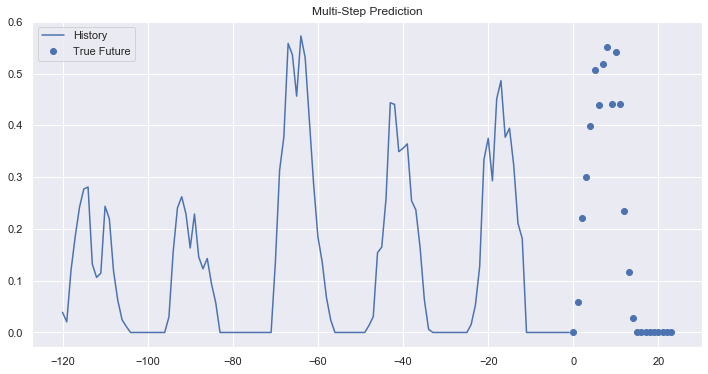

In [16]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]), 'Multi-Step Prediction')

In [12]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [13]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

Обучаем модель

Epoch 1/15
40/40 [==============================] - 38s 724ms/step - loss: 0.1619 - val_loss: 0.0942
Epoch 2/15
40/40 [==============================] - 28s 700ms/step - loss: 0.1430 - val_loss: 0.0863
Epoch 3/15
40/40 [==============================] - 27s 681ms/step - loss: 0.1386 - val_loss: 0.0847
Epoch 4/15
40/40 [==============================] - 27s 687ms/step - loss: 0.1314 - val_loss: 0.0840
Epoch 5/15
40/40 [==============================] - 27s 685ms/step - loss: 0.1229 - val_loss: 0.0831
Epoch 6/15
40/40 [==============================] - 28s 697ms/step - loss: 0.1156 - val_loss: 0.0821
Epoch 7/15
40/40 [==============================] - 27s 686ms/step - loss: 0.1093 - val_loss: 0.0814
Epoch 8/15
40/40 [==============================] - 31s 776ms/step - loss: 0.1039 - val_loss: 0.0811
Epoch 9/15
40/40 [==============================] - 62s 2s/step - loss: 0.0995 - val_loss: 0.0804
Epoch 10/15
40/40 [==============================] - 67s 2s/step - loss: 0.0960 - val_loss: 0.

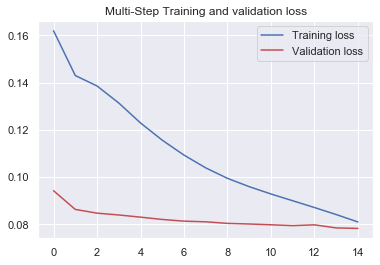

In [16]:
#%%script_false
EVALUATION_INTERVAL = 40 #200
EPOCHS = 15

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=10)

multi_step_model.save('E:\EZG\VIE\solar_lstm\multi_step_model.h5')

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

Сохраняем модель в файл

In [14]:
multi_step_model = tf.keras.models.load_model('E:\EZG\VIE\solar_lstm\multi_step_model.h5')

Строим пронозы на три случайные даты

7/7 [==============================] - 3s 89ms/step


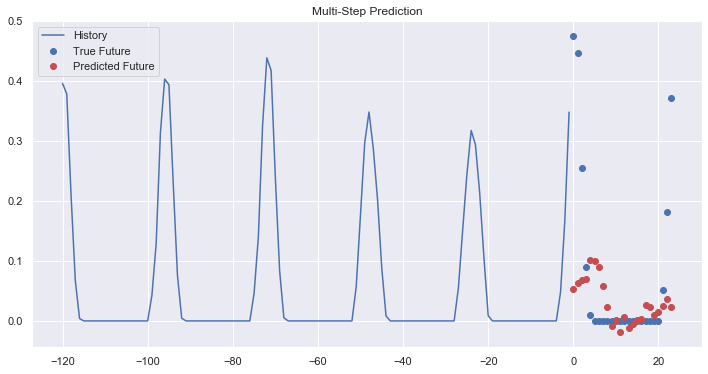

7/7 [==============================] - 0s 62ms/step


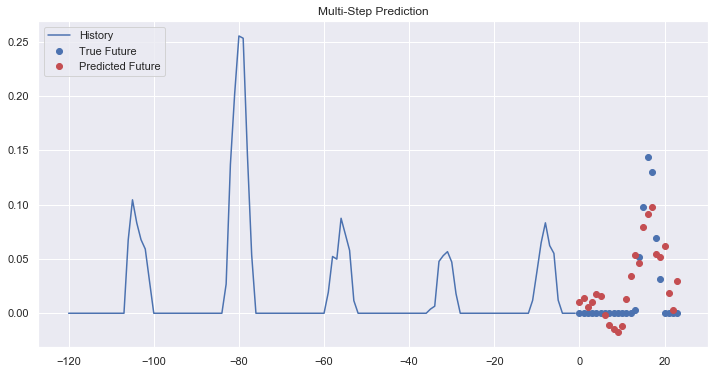

7/7 [==============================] - 1s 77ms/step


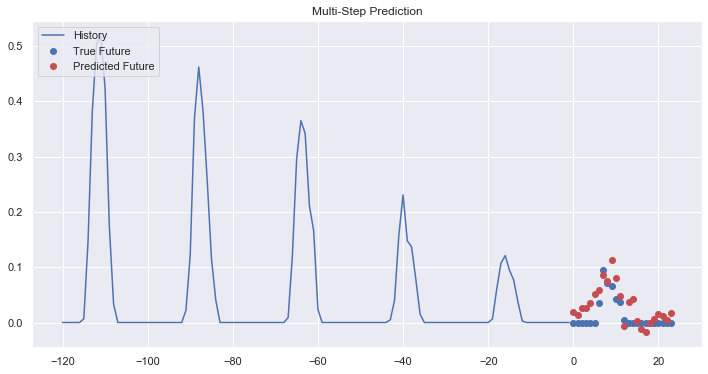

In [15]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], 'Multi-Step Prediction')

Строим прогноз на 28.02.2023

In [16]:
day_of_interest = datetime(2023, 2, 28)
prediction_period_first_date = day_of_interest - timedelta(days=5)
prediction_period_last_date = day_of_interest - timedelta(days=1)

day_of_interest = day_of_interest.strftime('%Y-%m-%d')
prediction_period_first_date = prediction_period_first_date.strftime('%Y-%m-%d')
prediction_period_last_date = prediction_period_last_date.strftime('%Y-%m-%d')

day_of_interest = features[day_of_interest+' 00:00:00':day_of_interest+' 23:00:00']
y_multi_target = day_of_interest.load_rate.values

In [17]:
pred_period = features[prediction_period_first_date+' 00:00:00':prediction_period_last_date+' 23:00:00']
pred_period = np.array(pred_period.values)
pred_period = pred_period.reshape((1,120,11))

pred_period_target = features['load_rate']
pred_period_target = pred_period_target[prediction_period_first_date+' 00:00:00':prediction_period_last_date+' 23:00:00']
pred_period_target = pd.DataFrame(pred_period_target)

1/1 [==============================] - 2s 2s/step


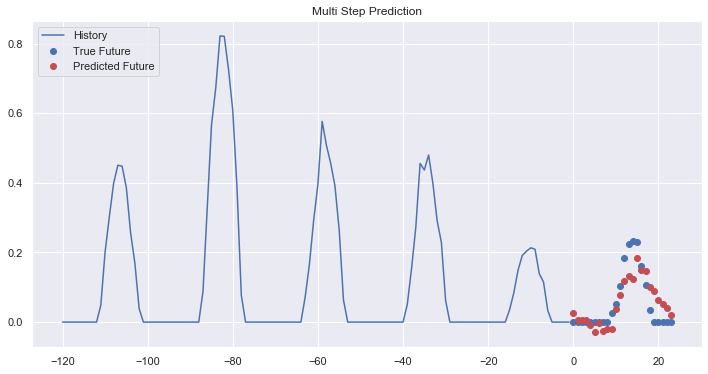

In [18]:
plot = multi_step_plot(pred_period_target.values, 
                       y_multi_target,
                       multi_step_model.predict(pred_period).reshape(24,), 
                       'Multi Step Prediction')

In [27]:
results = pd.DataFrame({"fact": y_multi_target,
                        "prediction": multi_step_model.predict(pred_period).reshape(24,)}
                        )
results['MAPE, %'] = 100*abs(results['fact'] - results['prediction'])/results['fact'].max()
print(f"MAPE: {round(results['MAPE, %'].mean(),2)}%")

1/1 [==============================] - 0s 51ms/step
MAPE: 16.34%


**Вывод**

Создали модель на основе метода LSTM. На тестовой дате средняя за 24 часа относительная ошибка прогнозирования составила 16.34%. В дальнейшем протестируем модель на более длинном временном интервале.